### Load libraries

In [ ]:
import os
import tqdm
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt

### Plot NMR Graph

In [ ]:
def plot_graph(G, fnmr, savefig=False):
    print(fnmr)
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o', 
        node_color=node_color)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)
    if savefig:
        plt.savefig(fnmr.replace('.nmr', '.pdf'), format='pdf')
    plt.show()

In [ ]:
wdir = 'DATA_TEST'
for fn in os.listdir(wdir):
    if not fn.startswith('testRAND') or not fn.endswith('.nmr'):
        continue
    fn = os.path.join(wdir, fn)
    nmr = NMR(fn)
    E, S = nmr.E, nmr.S
    G = nmr.ordering_graph
    plot_graph(G, fn, True)

### Read LOG Files

In [ ]:
WDIR = ['DATA_EPSD_00_DMAX_50', 'DATA_EPSD_00_DMAX_60']
df = []
for wdir in WDIR:
    print('Processing wdir=%s' % wdir)
    dmax = int(wdir.split('_')[-1])
    for flog in tqdm.tqdm(sorted(os.listdir(wdir))):
        if not flog.endswith('.log'):
            continue
        pid = flog.replace('.log','')
        flog = os.path.join(wdir, flog)
        # check if the problem was pickled        
        df_log = {'pid': pid, 'dmax':dmax}
        with open(flog, 'r') as fid:
            for row in fid:
                row = row.replace(':','').replace('\n','').split(' ')
                field = row[1]
                if 'fnmr' in field:
                    value = row[-1]
                elif 'timeoutBB' in field:
                    value = int(row[-1])
                elif 'time' in field:
                    value = float(row[-1])
                else:
                    value = int(row[-1])
                df_log[field] = value
        df.append(df_log)
df = pd.DataFrame(df)
df['gapRL'] = (df['costSB'] - df['costRX']) / df['costRX']
df['gapBB'] = (df['costSB'] - df['costBB']) / df['costBB']
df['gapPT'] = (df['costSB'] - df['costPT']) / df['costPT']
C = {'timeoutBB':'tOutBB','timeoutPT':'tOutPT'}
df.rename(columns=C, inplace=True)
df.drop(['fnmr'],axis=1,inplace=True)
fname = 'results.xlsx'
print('Save', fname)
df.to_excel(fname,index=False)
df.head()

In [ ]:
# time out cases
dfA = df[df['timeoutPT'] + df['timeoutBB'] >= 1]
dfA = dfA[['pid','dmax','costRELAX','costSBBU','costBB','costPT','gapRL','timeBB','timePT']]
dfA

In [ ]:
df.groupby(by=['pid','dmax']).mean()

In [ ]:
df50 = df[df['dmax']==50]
df60 = df[df['dmax']==60]

### Instance Analysis

In [27]:
fn  = 'DATA_EPSD_00_DMAX_50/1n6t.nmr'
nmr = NMR(fn)
E, S = nmr.E, nmr.S
print('len(E):',len(E),'len(S):',len(S))

len(E): 92 len(S): 27


DATA_TEST/testE.nmr


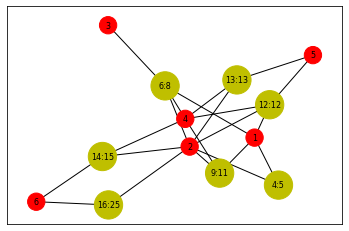

In [22]:
G = nmr.ordering_graph
plot_graph(G, fn, False)

In [23]:
order, costBF = order_brute(nmr)
print('costBF=',costBF)

costBF= 1072


In [29]:
x, y, z = [], [], []
for sid in S:
    s = S[sid]
    x.append(s.i)
    y.append(s.j)
    z.append('nmr')
    x.append(s.i)
    y.append(s.i)
    z.append('x==y')
df = {'x':x, 'y':y, 'z':z}
px.scatter(df, x='x', y='y', color='z')

In [30]:
for eid in E:
    e = E[eid]
    print(eid, e.i, e.j, e.sid)

4 1 5 {1, 2}
5 1 10 {1, 2, 3, 4, 5, 6, 7}
9 2 6 {2, 3}
10 2 7 {2, 3, 4}
11 2 10 {2, 3, 4, 5, 6, 7}
15 3 7 {3, 4}
16 3 8 {3, 4, 5}
17 3 9 {3, 4, 5, 6}
18 3 10 {3, 4, 5, 6, 7}
19 3 11 {3, 4, 5, 6, 7, 8}
20 3 12 {3, 4, 5, 6, 7, 8, 9}
21 3 13 {3, 4, 5, 6, 7, 8, 9, 10}
25 4 8 {4, 5}
26 4 9 {4, 5, 6}
27 4 10 {4, 5, 6, 7}
28 4 13 {4, 5, 6, 7, 8, 9, 10}
32 5 9 {5, 6}
33 5 10 {5, 6, 7}
34 5 13 {5, 6, 7, 8, 9, 10}
35 5 14 {5, 6, 7, 8, 9, 10, 11}
39 6 10 {6, 7}
40 6 11 {8, 6, 7}
41 6 12 {8, 9, 6, 7}
42 6 13 {6, 7, 8, 9, 10}
43 6 14 {6, 7, 8, 9, 10, 11}
44 6 15 {6, 7, 8, 9, 10, 11, 12}
45 6 16 {6, 7, 8, 9, 10, 11, 12, 13}
49 7 11 {8, 7}
50 7 12 {8, 9, 7}
51 7 13 {8, 9, 10, 7}
55 8 12 {8, 9}
56 8 13 {8, 9, 10}
57 8 16 {8, 9, 10, 11, 12, 13}
61 9 13 {9, 10}
62 9 14 {9, 10, 11}
63 9 15 {9, 10, 11, 12}
64 9 16 {9, 10, 11, 12, 13}
65 9 17 {9, 10, 11, 12, 13, 14}
69 10 14 {10, 11}
70 10 15 {10, 11, 12}
71 10 16 {10, 11, 12, 13}
75 11 15 {11, 12}
76 11 16 {11, 12, 13}
80 12 16 {12, 13}
81 12 17 {12, 13, 

In [32]:
S[1].i, S[1].j

(4, 4)

In [ ]:
# degree of each segment
degree = {}
for sid in S:
    s: NMRSegment = S[sid]
    d = len(s.eid)
    if d not in degree:
        degree[d] = 0
    degree[d] += 1
# convert from dict to list
degree = sorted([(d, degree[d]) for d in degree])


In [ ]:
x, y = list(zip(*degree))
df = {'segment degree':x,'#occurrencies':y}
px.scatter(df,x='segment degree',y='#occurrencies')

In [ ]:
# any pair of segments have the same edges? 
K = set()
for sid in tqdm.tqdm(S):
    s: NMRSegment = S[sid]
    K.add(tuple(sorted(eid for eid in s.eid)))
print('#K:',len(K), '#S:', len(S))

In [ ]:
# remover de (edge) 'a' de s.sid se existir (edge) 'b' s.sid tq b \subset a.
import copy
W = copy.deepcopy(S)
df = {'sid':[], 'degOld':[], 'degNew':[]}
for sid in tqdm.tqdm(sorted(W)):
    s : NMRSegment = W[sid]
    s_eid = sorted(s.eid)
    R = set() # eid to be removed
    for eidA in s_eid:
        a: NMREdge = E[eidA]
        for eidB in s_eid:
            if eidA == eidB:
                continue
            b: NMREdge = E[eidB]
            # a contains b, so b precedes a
            if a.i <= b.i and b.j <= a.j:
                R.add(eidA)
                break
    s.eid = s.eid - R
    df['sid'].append(sid)
    df['degOld'].append(len(s_eid))
    df['degNew'].append(len(s.eid))


In [ ]:
px.scatter(df, x='degOld', y='degNew', text='sid')

In [ ]:
sid = 623
s = S[sid]
for eid in s.eid:
    e: NMREdge = E[eid]
    print('(%d, %d)' % (e.i, e.j))


In [ ]:
sid = 623
s = W[sid]
for eid in s.eid:
    e: NMREdge = E[eid]
    print('(%d, %d)' % (e.i, e.j))


In [ ]:
s.i, s.j